In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, label
from IPython.display import FileLink

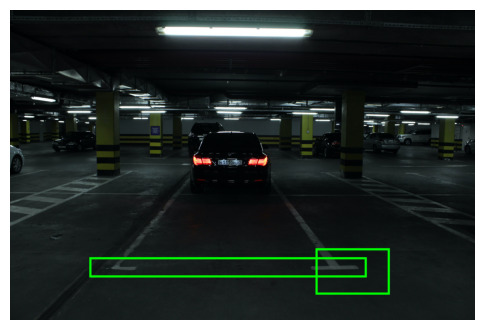

In [20]:
# Загрузка и отображение изображения bbox.jpg
bbox_image = Image.open('bbox.jpg')

# Отображение изображения
plt.figure(figsize=(6, 6))
plt.imshow(bbox_image)
plt.axis('off')
plt.show()

In [ ]:
# --- Настройки ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "deeplabv3p_epoch25.pth"
IMAGE_PATH = "original.jpg"

# --- Инициализация модели ---
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=False, num_classes=2)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# --- Удаление несоответствующих ключей ---
filtered_state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
model.load_state_dict(filtered_state_dict, strict=False)

model.to(DEVICE)
model.eval()

# --- Преобразование тестового изображения ---
image = Image.open(IMAGE_PATH).convert("RGB")
original_size = image.size  # Сохраняем исходный размер

transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Приведение изображения к фиксированному размеру
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

input_tensor = transform(image).unsqueeze(0).to(DEVICE)

# --- Прогнозирование ---
with torch.no_grad():
    with torch.amp.autocast("cuda"):
        output = model(input_tensor)["out"]
pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

<ipython-input-22-aec5784accf5>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
/usr/local/lib/python3.10/dist-pac

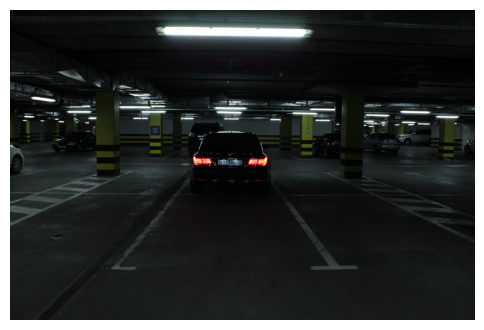

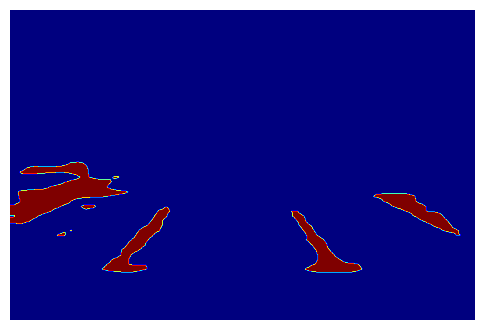

In [4]:
# --- Масштабирование маски до исходного размера ---
pred_mask_resized = Image.fromarray(pred_mask.astype('uint8'))
pred_mask_resized = pred_mask_resized.resize(original_size, Image.NEAREST)
pred_mask_resized = np.array(pred_mask_resized)

# --- Отображение оригинала ---
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

# --- Отображение маски ---
plt.figure(figsize=(6, 6))
plt.imshow(pred_mask_resized, cmap="jet")
plt.axis('off')
plt.show()

In [ ]:
# Сохранение оригинала изображения в формате JPG
image.save('original.jpg', 'JPEG')

# Сохранение маски в формате JPG
pred_mask_resized_image = Image.fromarray(pred_mask_resized.astype('uint8'))
pred_mask_resized_image.save('pred_mask_resized.jpg', 'JPEG')

FileLink('original.jpg'), FileLink('pred_mask_resized.jpg')

(/content/original_image.jpg, /content/pred_mask_resized.jpg)

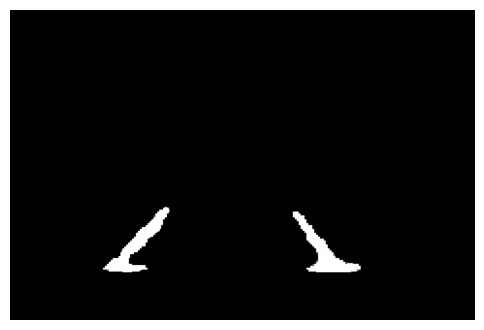

In [19]:
segmentation_image = Image.open('pred_mask_resized.jpg')
bbox_image = Image.open('bbox.jpg')

# Приводим изображения к одинаковому размеру (по размеру изображения с баундинг боксом)
segmentation_image = segmentation_image.resize(bbox_image.size, Image.Resampling.LANCZOS)

segmentation = np.array(segmentation_image)
bbox = np.array(bbox_image)

red_mask = (segmentation == 1)
green_mask = np.all((bbox >= [0, 200, 0]) & (bbox <= [50, 255, 50]), axis=-1)

# Найдем координаты зеленого прямоугольника
rows, cols = green_mask.shape

# Инициализация значений для минимальных и максимальных координат
y_min, y_max = None, None
x_min, x_max = None, None

# Поиск зеленых пикселей и вычисление границ
for i in range(rows):
    for j in range(cols):
        if green_mask[i, j]:
            if y_min is None or i < y_min:
                y_min = i
            if y_max is None or i > y_max:
                y_max = i
            if x_min is None or j < x_min:
                x_min = j
            if x_max is None or j > x_max:
                x_max = j

# Если не найдено зеленых пикселей, не создаем маску баундинг бокса
if None in [y_min, y_max, x_min, x_max]:
    print("Зеленые пиксели не найдены в маске!")
else:
    # Маска для области внутри баундинг бокса
    bbox_mask = np.zeros_like(green_mask, dtype=bool)
    bbox_mask[y_min:y_max+1, x_min:x_max+1] = True  # Маска для области внутри баундинг бокса

    # Расширяем маску баундинг бокса для захвата соприкасающихся объектов
    expanded_bbox_mask = binary_dilation(bbox_mask, structure=np.ones((10, 10)))  # Расширяем маску для захвата соприкасающихся объектов

# Теперь найдем все объекты (сегменты), которые соприкасаются с баундинг боксом
labeled_segments, num_segments = label(red_mask)

# Для каждого сегмента проверяем, пересекается ли он с расширенной маской баундинг бокса
result_mask = np.zeros_like(red_mask, dtype=bool)

for segment_id in range(1, num_segments + 1):
    # Находим координаты всех пикселей этого сегмента
    segment_mask = (labeled_segments == segment_id)

    # Если хотя бы один пиксель этого сегмента пересекается с расширенной маской баундинг бокса
    if np.any(segment_mask & expanded_bbox_mask):
        result_mask |= segment_mask  # Добавляем весь сегмент в результат

# Преобразуем результат в изображение
result = np.zeros_like(red_mask, dtype=np.uint8)
result[result_mask] = 255  # Сохраняем только те пиксели, которые относятся к пересекающимся сегментам
result_image = Image.fromarray(result)

# Сохранение и отображение результата
result_image.save('result.png')
plt.figure(figsize=(6, 6))
plt.imshow(result_image, cmap='gray')
plt.axis('off')
plt.show()